## Thiết kế mô hình localization cho đối tượng trong hình
- Gồm có 4 nhãn:
    + (0, 1): class của đối tượng
    + x1: Hoành độ của điểm góc trên bên trái bounding box
    + y1: Tung độ của điểm góc trên bên trái bounding box
    + x2: Hoành độ của điểm góc dưới bên phải bounding box
    + y2: Tung độ của điểm góc dưới bên phải bounding box
* Các bước thực hiện:
  - Thu thập ảnh cho 2 loại đối tượng (chó, mèo, gà, ...): mỗi đối tượng 500 ảnh
  - Gán nhãn cho đối tượng bằng anylabeling
  - Huấn luyện mô hình:
    + Input: (224, 224)
    + 32 Conv2D 3x3
    + MaxPooling
    + 64 Conv2D 3x3
    + MaxPooling
    + 128 Conv2D 3x3
    + MaxPooling
    + Flatten
    + FC 128
    + FC 5

In [1]:
import numpy as np
import json
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import random

import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Read data and create dataloader

In [3]:
train_fire_hydrant_dir = "Data/Train/fire hydrant"
train_teapot_dir = "Data/Train/teapot"

val_fire_hydrant_dir = "Data/Val/fire hydrant"
val_teapot_dir = "Data/Val/teapot"

In [4]:
def add_to_dataframe(dir_path, df):
    for filename in os.listdir(dir_path):
        if filename.endswith("json"):
            f = open(os.path.join(dir_path, filename))
            content_json = json.load(f)
            
            label = content_json["shapes"][0]["label"]
            label = 0 if label=="fire hydrant" else 1
            
            points = content_json["shapes"][0]["points"]
            x1 = points[0][0]
            y1 = points[0][1]
            x2 = points[1][0]
            y2 = points[1][1]
            imagePath = os.path.join(dir_path, content_json["imagePath"])

            # Bỏ vào df
            new_row = {"label":label, "x1":x1, "y1":y1, "x2":x2, "y2":y2, "imagePath":imagePath}
            df = df._append(new_row, ignore_index=True)
            
            f.close()
    
    return df

In [5]:
# Dataframe chứa các nhãn
train_df = pd.DataFrame(columns=["label", "x1", "y1", "x2", "y2", "imagePath"])
val_df = pd.DataFrame(columns=["label", "x1", "y1", "x2", "y2", "imagePath"])

# Bỏ dữ liệu của các file gán nhãn vào dataframe
train_df = add_to_dataframe(train_fire_hydrant_dir, df=train_df)
train_df = add_to_dataframe(train_teapot_dir, df=train_df)

val_df = add_to_dataframe(val_fire_hydrant_dir, df=val_df)
val_df = add_to_dataframe(val_teapot_dir, df=val_df)

In [6]:
train_df

,label,x1,y1,x2,y2,imagePath
0,0,142.466830,183.253071,173.000000,223.000000,Data/Train/fire hydrant\1.jpg
1,0,78.584767,78.093366,137.552826,168.265356,Data/Train/fire hydrant\10.jpg
2,0,27.233415,29.444717,191.852580,201.926290,Data/Train/fire hydrant\100.jpg
3,0,14.948403,24.530713,84.481572,207.577396,Data/Train/fire hydrant\101.jpg
4,0,27.970516,2.663391,198.732187,219.371007,Data/Train/fire hydrant\102.jpg
...,...,...,...,...,...,...
495,1,8.314496,9.542998,212.737101,219.371007,Data/Train/teapot\95.jpg
496,1,159.911548,117.896806,191.606880,163.597052,Data/Train/teapot\96.jpg
497,1,39.764128,21.090909,206.594595,165.562654,Data/Train/teapot\97.jpg
498,1,117.896806,75.882064,206.348894,166.299754,Data/Train/teapot\98.jpg


In [7]:
val_df

,label,x1,y1,x2,y2,imagePath
0,0,35.832924,3.646192,164.088452,192.098280,Data/Val/fire hydrant\251.jpg
1,0,56.717445,47.626536,154.506143,162.122850,Data/Val/fire hydrant\252.jpg
2,0,68.019656,122.073710,128.216216,208.314496,Data/Val/fire hydrant\253.jpg
3,0,50.083538,70.230958,104.628993,203.400491,Data/Val/fire hydrant\254.jpg
4,0,162.122850,78.584767,209.788698,194.555283,Data/Val/fire hydrant\255.jpg
...,...,...,...,...,...,...
99,1,9.297297,12.982801,206.348894,194.555283,Data/Val/teapot\287.jpg
100,1,9.788698,62.614251,110.034398,213.474201,Data/Val/teapot\288.jpg
101,1,110.034398,6.103194,221.336609,113.965602,Data/Val/teapot\289.jpg
102,1,28.953317,42.958231,123.056511,182.761671,Data/Val/teapot\290.jpg


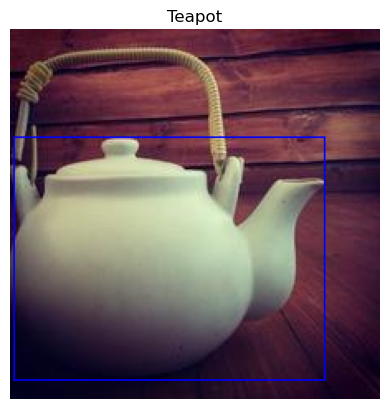

In [8]:
# Hiển thị hình ảnh và nhãn của nó
index = np.random.randint(0, 500)

label = train_df.iloc[index][0]
x1 = train_df.iloc[index]['x1']
y1 = train_df.iloc[index]['y1']
x2 = train_df.iloc[index]['x2']
y2 = train_df.iloc[index]['y2']

test_im = cv2.imread(train_df.iloc[index]["imagePath"])
test_im = cv2.cvtColor(test_im, cv2.COLOR_BGR2RGB)
test_im = cv2.rectangle(test_im, (int(x1), int(y1)), (int(x2), int(y2)), color=(0, 0, 255))

plt.imshow(test_im)
plt.title("Fire hydrant" if label==0 else "Teapot")
plt.axis("off")
plt.show()

In [9]:
class MyDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        # read the image
        imagePath = self.dataframe.iloc[index]['imagePath']
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image.astype(np.float32) / 255.0
        
        if self.transform:
            image = self.transform(image)
        
        # read the label
        label = self.dataframe.iloc[index]['label']
        
        # read the bounding box
        x1 = np.float32(self.dataframe.iloc[index]['x1'])
        y1 = np.float32(self.dataframe.iloc[index]['y1'])
        x2 = np.float32(self.dataframe.iloc[index]['x2'])
        y2 = np.float32(self.dataframe.iloc[index]['y2'])
        box = np.array([x1, y1, x2, y2])
        
        return image, label, box

In [10]:
def create_dataloader(dataframe, batch_size):
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    dataset = MyDataset(dataframe=dataframe, transform=transform)
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
    
    return dataloader

### Kiến trúc model

In [11]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3)
        
        self.max_pool2d = nn.MaxPool2d(kernel_size=2)
        self.flatten = nn.Flatten()

        self.fc1 = nn.Linear(in_features=128*26*26, out_features=128)
        
        # Connecting CNN outputs with Fully Connected layers for classification
        self.fc_class = nn.Linear(in_features=128, out_features=1)
        
        # Connecting CNN outputs with Fully Connected layers for bounding box
        self.fc_box = nn.Linear(in_features=128, out_features=4)
        
    
    def forward(self, x):
        x = self.max_pool2d(torch.relu(self.conv1(x)))
        x = self.max_pool2d(torch.relu(self.conv2(x)))
        x = self.max_pool2d(torch.relu(self.conv3(x)))
        x = self.flatten(x)
        x = self.fc1(x)
        x = torch.relu(x)
        
        # classification with sigmoid
        class_x = self.fc_class(x)
        class_x = torch.sigmoid(class_x)
        
        # bounding box with no activation function
        box_x = self.fc_box(x)
        
        return [class_x, box_x]

### Huấn luyện mô hình

In [12]:
train_dataloader = create_dataloader(dataframe=train_df, batch_size=32)
val_dataloader = create_dataloader(dataframe=val_df, batch_size=32)

In [13]:
def calculate_iou(box1, box2):
    # Tính toán diện tích của các bounding box
    area_box1 = (box1[:, 2] - box1[:, 0]) * (box1[:, 3] - box1[:, 1])
    area_box2 = (box2[:, 2] - box2[:, 0]) * (box2[:, 3] - box2[:, 1])

    # Tính toán toạ độ của bounding box chung
    x1 = torch.max(box1[:, 0], box2[:, 0])
    y1 = torch.max(box1[:, 1], box2[:, 1])
    x2 = torch.min(box1[:, 2], box2[:, 2])
    y2 = torch.min(box1[:, 3], box2[:, 3])

    # Tính toán diện tích của bounding box chung
    intersection_area = torch.clamp(x2 - x1, min=0) * torch.clamp(y2 - y1, min=0)

    # Tính toán IoU
    iou = intersection_area / (area_box1 + area_box2 - intersection_area)

    return iou

In [14]:
# Khởi tạo model
model = MyModel()
model.to(device=device)

optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

num_epochs = 50

arr_train_loss = []
arr_val_loss = []
arr_epoch = []

for epoch in range(num_epochs):
    train_loss = 0.0
    val_loss = 0.0
    train_iou = 0.0
    val_iou = 0.0
    train_num_cor = 0
    val_num_cor = 0

    
    model.train()
    for images, labels, boxes in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        boxes = boxes.to(device)

        optimizer.zero_grad()
        
        [class_pred, box_pred] = model(images)
        
        # compute loss
        class_loss = F.binary_cross_entropy(class_pred, labels.unsqueeze(1).float())
        predictions = torch.round(class_pred).squeeze()
        num_correct = torch.sum((predictions == labels)).item()
        train_num_cor += num_correct
        
        
        box_loss = F.mse_loss(box_pred, boxes)
        
        iou_sum = torch.sum(calculate_iou(box_pred, boxes))
        train_iou += iou_sum.item()
        
        train_loss += (class_loss.item()*images.size(0)+box_loss.item()*images.size(0))
        
        (class_loss+box_loss).backward()
        optimizer.step()
        

    model.eval()
    
    for images, labels, boxes in val_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        boxes = boxes.to(device)
        
        with torch.no_grad():
            [class_pred, box_pred] = model(images)

            # compute loss
            class_loss = F.binary_cross_entropy(class_pred, labels.unsqueeze(1).float())
            predictions = torch.round(class_pred).squeeze()
            num_correct = torch.sum((predictions == labels)).item()
            val_num_cor += num_correct
            box_loss = F.mse_loss(box_pred, boxes)
            
            iou_sum = torch.sum(calculate_iou(box_pred, boxes))
            val_iou += iou_sum.item()
            val_loss += (class_loss.item()*images.size(0)+box_loss.item()*images.size(0))
            
    train_loss /= len(train_dataloader.dataset)
    val_loss/= len(val_dataloader.dataset)
    train_iou /= len(train_dataloader.dataset)
    val_iou /= len(val_dataloader.dataset)
    train_acc = train_num_cor/ len(train_dataloader.dataset)
    val_acc = val_num_cor / len(val_dataloader.dataset)

    arr_train_loss.append(train_loss)
    arr_val_loss.append(val_loss)
    arr_epoch.append(epoch+1)

    print(f"Epoch {epoch+1}/{num_epochs}, Train_loss: {train_loss}, val_loss: {val_loss}, train_IoU: {train_iou}, val_IoU: {val_iou}, train_acc: {train_acc:.3f}, val_acc: {val_acc:.3f}")

Epoch 1/50, Train_loss: 7114.12934154129, val_loss: 1568.3184596942021, train_IoU: 0.1616862326299306, val_IoU: 0.46390196910271275, train_acc: 0.514, val_acc: 0.606
Epoch 2/50, Train_loss: 2306.5175695967673, val_loss: 1110.2408791872172, train_IoU: 0.32356106758117675, val_IoU: 0.5046570209356455, train_acc: 0.496, val_acc: 0.596
Epoch 3/50, Train_loss: 1727.8440953798295, val_loss: 1275.6970957150827, train_IoU: 0.36536436271667483, val_IoU: 0.43546627576534563, train_acc: 0.520, val_acc: 0.606
Epoch 4/50, Train_loss: 1614.2259503164291, val_loss: 1110.7462732516801, train_IoU: 0.3821572780609131, val_IoU: 0.47240894115888155, train_acc: 0.496, val_acc: 0.606
Epoch 5/50, Train_loss: 1532.7816766800881, val_loss: 1230.5367394869145, train_IoU: 0.38790948963165284, val_IoU: 0.43318321383916414, train_acc: 0.510, val_acc: 0.452
Epoch 6/50, Train_loss: 1546.7150456762313, val_loss: 1254.7086803729717, train_IoU: 0.3847422504425049, val_IoU: 0.4234870167878958, train_acc: 0.510, val_acc:

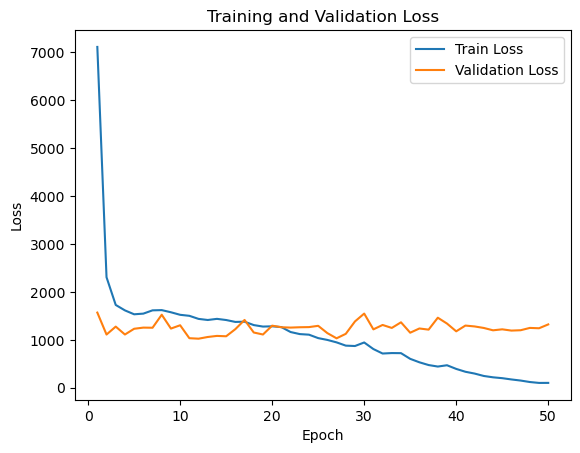

In [15]:
# Vẽ biểu đồ
plt.plot(arr_epoch, arr_train_loss, label='Train Loss')
plt.plot(arr_epoch, arr_val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

### Save model

In [16]:
torch.save(model.state_dict(), "Models/trained_model.pth")

### Kiểm tra thử kết quả

In [17]:
def show_result(model, image_path):
    test_image = cv2.imread(image_path)
    test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
    test_image = cv2.resize(test_image, (224, 224))
    show_im = test_image.copy()
    
    test_image = np.float32(test_image) / 255.0
    transform = transforms.ToTensor()
    test_image_tensor = transform(test_image)
    test_image_tensor = test_image_tensor.unsqueeze(0)
    test_image_tensor = test_image_tensor.to(device)

    model.eval()
    with torch.no_grad():
        [class_pred, box_pred] = model(test_image_tensor)


    label = "fire hydrant" if class_pred.item()<=0.5 else "teapot"

    x1 = box_pred[0][0]
    y1 = box_pred[0][1]
    x2 = box_pred[0][2]
    y2 = box_pred[0][3]

    pt1 = (int(x1), int(y1))
    pt2 = (int(x2), int(y2))

    show_im = cv2.rectangle(show_im, pt1, pt2, (0,255,255))
    plt.imshow(show_im)
    plt.title(label)
    plt.axis("off")
    plt.show()

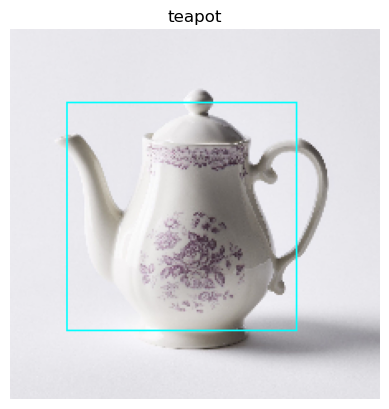

In [20]:
path = "2.jpg"
show_result(model, path)